In [171]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from utils import read_log

In [172]:
def reversion_half_life(spread: pd.Series):
    spread = spread.dropna()
    x_lag = spread.shift(1).dropna()
    x_ret = spread.diff().dropna()

    # OLS regression: dx = theta * (mu - x)
    model = OLS(x_ret, add_constant(x_lag)).fit()
    beta = model.params.to_numpy()[1]
    theta = -np.log(1 + beta) if beta > -1 else 0

    if theta <= 0:
        return np.inf  # No mean reversion
        
    half_life = np.log(2) / theta
    return half_life

In [173]:
def get_spreads(prices):
    cro = prices[prices['product'] == 'CROISSANTS'].reset_index(drop=True)
    jam = prices[prices['product'] == 'JAMS'].reset_index(drop=True)
    dje = prices[prices['product'] == 'DJEMBES'].reset_index(drop=True)
    bas1 = prices[prices['product'] == 'PICNIC_BASKET1'].reset_index(drop=True)
    bas2 = prices[prices['product'] == 'PICNIC_BASKET2'].reset_index(drop=True)
    
    syn1 = 6 * cro['mid_price'] + 3 * jam['mid_price'] + dje['mid_price']
    syn2 = 4 * cro['mid_price'] + 2 * jam['mid_price']
    
    spr1 = bas1['mid_price'] - syn1
    spr2 = bas2['mid_price'] - syn2
    spr3 = spr1 - spr2

    return spr1, spr2, spr3

PICNIC_BASKET1:
- Six (6) CROISSANTS
- Three (3) JAMS
- One (1) DJEMBE

PICNIC_BASKET2:
- Four (4) CROISSANTS
- Two (2) JAMS

# Round 2

In [3]:
price_0 = pd.read_csv('../data/raw/round_2/prices_round_2_day_-1.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_2/prices_round_2_day_0.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_2/prices_round_2_day_1.csv', delimiter=';')

In [4]:
trades_0 = pd.read_csv('../data/raw/round_2/trades_round_2_day_-1.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_2/trades_round_2_day_0.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_2/trades_round_2_day_1.csv', delimiter=';')

In [5]:
prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

In [6]:
cro = prices[prices['product'] == 'CROISSANTS'].reset_index(drop=True)
jam = prices[prices['product'] == 'JAMS'].reset_index(drop=True)
dje = prices[prices['product'] == 'DJEMBES'].reset_index(drop=True)
bas1 = prices[prices['product'] == 'PICNIC_BASKET1'].reset_index(drop=True)
bas2 = prices[prices['product'] == 'PICNIC_BASKET2'].reset_index(drop=True)

syn1 = 6 * cro['mid_price'] + 3 * jam['mid_price'] + dje['mid_price']
syn2 = 4 * cro['mid_price'] + 2 * jam['mid_price']
spr1 = bas1['mid_price'] - syn1
spr2 = bas2['mid_price'] - syn2

spr3 = spr1 - spr2
spr1z = (spr1 - spr1.mean()) / spr1.std()
spr2z = (spr2 - spr2.mean()) / spr2.std()
spr3z = (spr3 - spr3.mean()) / spr3.std()

In [7]:
spr1.mean(), spr1.std()

(np.float64(48.762433333333334), np.float64(85.11945080948944))

In [8]:
spr2.mean(), spr2.std()

(np.float64(30.235966666666666), np.float64(59.849200222652364))

In [9]:
spr3.mean(), spr3.std()

(np.float64(18.526466666666668), np.float64(80.33068674852721))

In [10]:
print(reversion_half_life(spr1z))
print(reversion_half_life(spr2z))
print(reversion_half_life(spr3z))

694.8219585388605
941.6255380562789
631.3798784276601


In [11]:
results = {}
for a in range(-6, 7):
    for b in range(-6, 7):
        spr = a * spr1 - b * spr2
        results[(a, b)] = reversion_half_life(spr)

In [12]:
min(results.values())

np.float64(625.5215227898661)

In [13]:
[k for k in results.keys() if results[k] == min(results.values())]

[(-5, -4), (5, 4)]

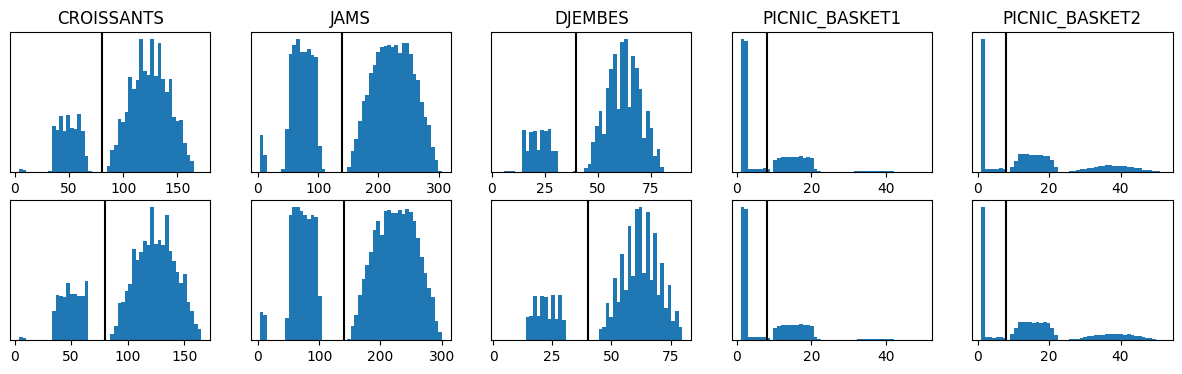

In [14]:
thrs = [80, 140, 40, 8, 8]

fig, ax = plt.subplots(2, 5, figsize=(15, 4))
for i, prod in enumerate([cro, jam, dje, bas1, bas2]):
    ax[0, i].hist(prod['bid_volume_1'], bins=50)
    ax[1, i].hist(prod['ask_volume_1'], bins=50)
    ax[0, i].axvline(thrs[i], c='k')
    ax[1, i].axvline(thrs[i], c='k')
    ax[0, i].set_title(prod.iloc[0]['product'])
    ax[0, i].set_yticks([])
    ax[1, i].set_yticks([])
plt.show()

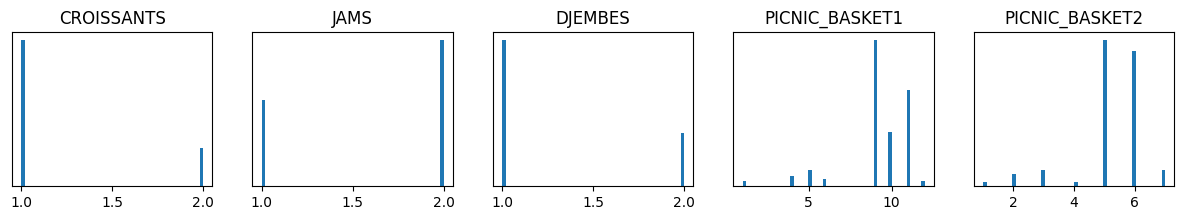

In [15]:
fig, ax = plt.subplots(1, 5, figsize=(15, 2))
for i, prod in enumerate([cro, jam, dje, bas1, bas2]):
    ax[i].hist(prod['ask_price_1'] - prod['bid_price_1'], bins=50)
    ax[i].set_title(prod.iloc[0]['product'])
    ax[i].set_yticks([])
plt.show()

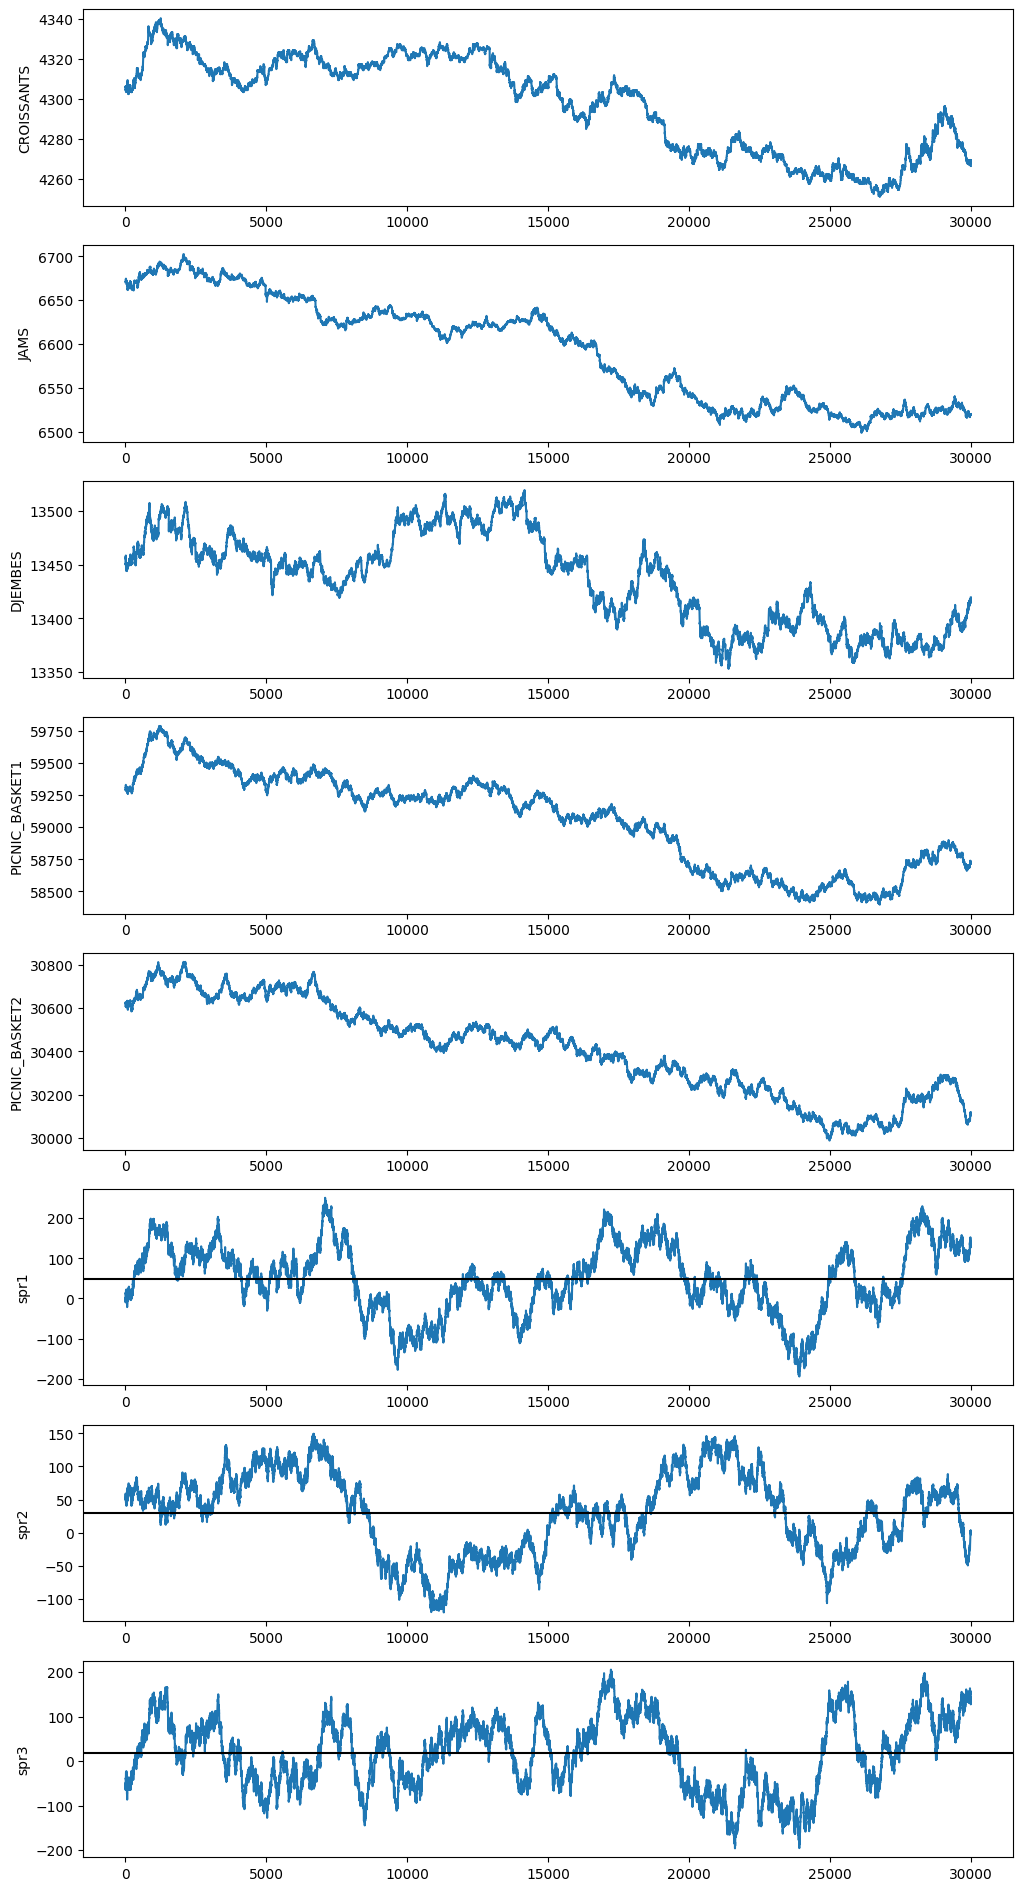

In [16]:
names = ['CROISSANTS', 'JAMS', 'DJEMBES', 'PICNIC_BASKET1', 'PICNIC_BASKET2', 'spr1', 'spr2', 'spr3']
fig, ax = plt.subplots(8, 1, figsize=(12, 24))
for i, prod in enumerate([cro['mid_price'], jam['mid_price'], dje['mid_price'], bas1['mid_price'], bas2['mid_price'], spr1, spr2, spr3]):
    ax[i].plot(prod)
    ax[i].set_ylabel(names[i])
ax[5].axhline(spr1.mean(), c='k')
ax[6].axhline(spr2.mean(), c='k')
ax[7].axhline(spr3.mean(), c='k')
plt.show()

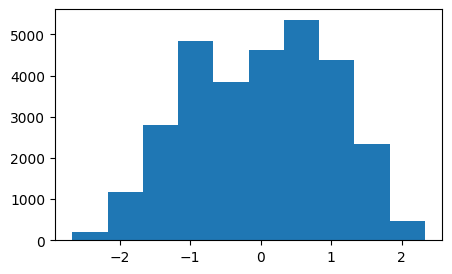

In [17]:
plt.figure(figsize=(5, 3))
plt.hist(spr3z, bins=10)
plt.show()

In [18]:
spr3.mean(), spr3.std()

(np.float64(18.526466666666668), np.float64(80.33068674852721))

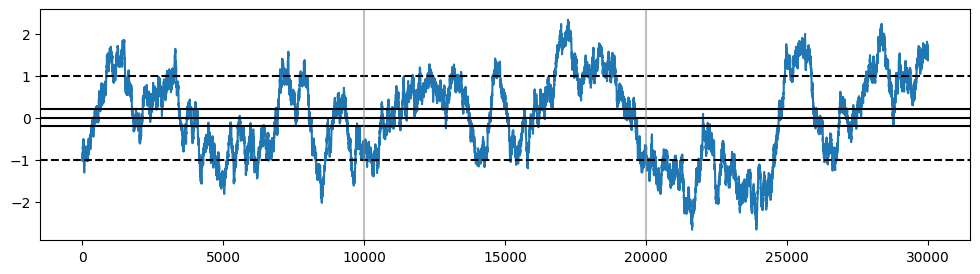

In [19]:
plt.figure(figsize=(12, 3))
plt.plot(spr3z)
plt.axhline(0, c='k')
plt.axhline(0.2, c='k')
plt.axhline(-0.2, c='k')
plt.axhline(1, c='k', linestyle='dashed')
plt.axhline(-1, c='k', linestyle='dashed')
plt.axvline(10000, c='gray', alpha=0.5)
plt.axvline(20000, c='gray', alpha=0.5)
plt.show()

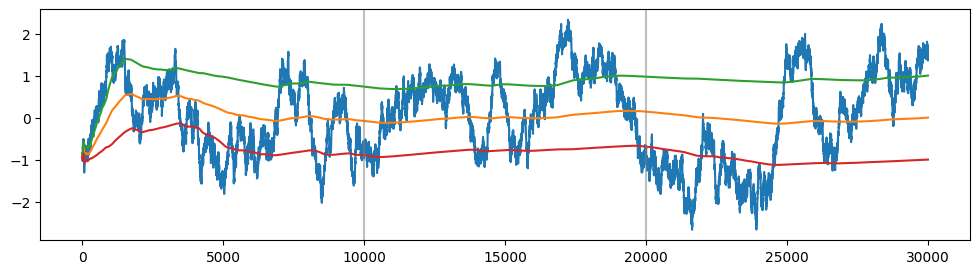

In [20]:
plt.figure(figsize=(12, 3))
plt.plot(spr3z)
plt.plot(spr3z.expanding().mean())
plt.plot(spr3z.expanding().mean() + spr3z.expanding().std())
plt.plot(spr3z.expanding().mean() - spr3z.expanding().std())
# plt.plot(spr3z.expanding().mean() + 4 * spr3z.rolling(100).std())
# plt.plot(spr3z.expanding().mean() - 4 * spr3z.rolling(100).std())
plt.axvline(10000, c='gray', alpha=0.5)
plt.axvline(20000, c='gray', alpha=0.5)
plt.show()

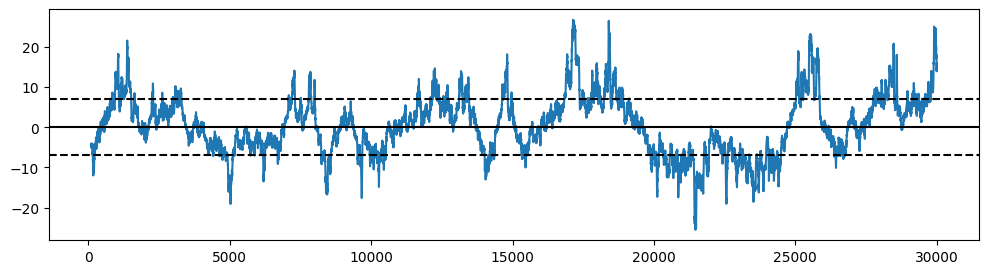

In [21]:
thr = 7
plt.figure(figsize=(12, 3))
plt.plot((spr3 - spr3.mean()) / spr3.rolling(100).std())
plt.axhline(0, c='k')
plt.axhline(thr, c='k', linestyle='dashed')
plt.axhline(-thr, c='k', linestyle='dashed')
# plt.ylim([-thr, thr])
# plt.axvline(10000, c='gray', alpha=0.5)
# plt.axvline(20000, c='gray', alpha=0.5)
plt.show()

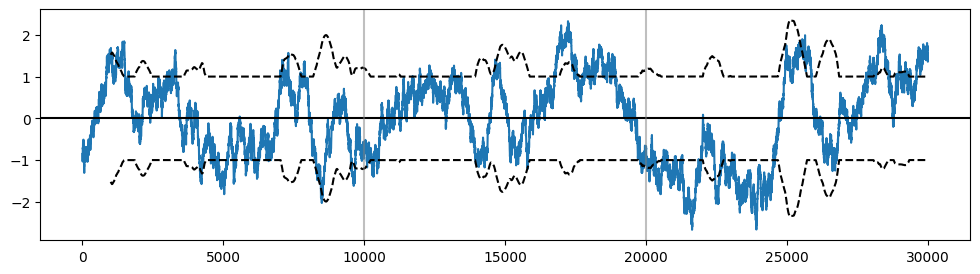

In [22]:
plt.figure(figsize=(12, 3))
plt.plot(spr3z)
plt.axhline(0, c='k')
plt.plot(np.maximum(2 * spr3z.rolling(1000).std(), np.ones(spr3z.shape[0])), c='k', linestyle='dashed')
plt.plot(-np.maximum(2 * spr3z.rolling(1000).std(), np.ones(spr3z.shape[0])), c='k', linestyle='dashed')
plt.axvline(10000, c='gray', alpha=0.5)
plt.axvline(20000, c='gray', alpha=0.5)
plt.show()

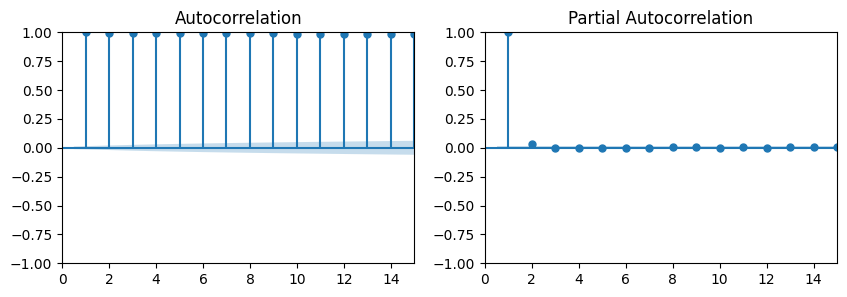

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(spr3, ax=ax[0], zero=False)
plot_pacf(spr3, ax=ax[1], zero=False)
ax[0].set_xlim([0, 15])
ax[1].set_xlim([0, 15])
plt.show()

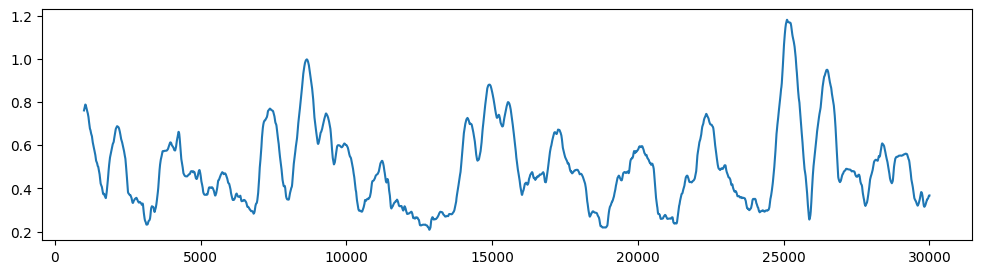

In [24]:
plt.figure(figsize=(12, 3))
plt.plot(spr3z.rolling(1000).std())
plt.show()

# Round 3

In [26]:
# Round 2 data bottle

price_0 = pd.read_csv('../data/raw/round_2/prices_round_2_day_-1.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_2/prices_round_2_day_0.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_2/prices_round_2_day_1.csv', delimiter=';')

prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
spr12, spr22, spr32 = get_spreads(prices)

In [27]:
# Round 2 website

_, prices, _ = read_log('../data/logs/round_2/9547fd05-1a01-43b1-b6cc-b4dd5c557d2c.log')
spr12w, spr22w, spr32w = get_spreads(prices)

In [28]:
# Round 2 final

_, prices, _ = read_log('../data/logs/round_2/351a5708-c942-4a38-995c-b5e139cc1bc7_final.log')
spr12f, spr22f, spr32f = get_spreads(prices)

In [29]:
# Round 3 data bottle

price_0 = pd.read_csv('../data/raw/round_3/prices_round_3_day_0.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_3/prices_round_3_day_1.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_3/prices_round_3_day_2.csv', delimiter=';')

prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
spr13, spr23, spr33 = get_spreads(prices)

In [30]:
# Round 3 website

_, prices, _ = read_log('../data/logs/round_3/9353836d-3f84-4413-9f28-3133983366e9.log')
spr13w, spr23w, spr33w = get_spreads(prices)

FileNotFoundError: [Errno 2] No such file or directory: '../data/logs/round_3/9353836d-3f84-4413-9f28-3133983366e9.log'

In [ ]:
plt.figure(figsize=(12, 4))
idx = 0
for spr in [spr12, spr12w, spr12f, spr13, spr13w]:
    plt.plot(np.arange(idx, idx + len(spr)), spr)
    idx += len(spr)
plt.title('Spread 1')
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
idx = 0
for spr in [spr22, spr22w, spr22f, spr23, spr23w]:
    plt.plot(np.arange(idx, idx + len(spr)), spr)
    idx += len(spr)
plt.title('Spread 2')
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
idx = 0
for spr in [spr32, spr32w, spr32f, spr33, spr33w]:
    plt.plot(np.arange(idx, idx + len(spr)), spr)
    idx += len(spr)
plt.title('Spread 3')
plt.show()

In [ ]:
spr1 = pd.concat([spr12, spr12w, spr12f, spr13, spr13w]).reset_index(drop=True)
spr2 = pd.concat([spr22, spr22w, spr22f, spr23, spr23w]).reset_index(drop=True)
spr3 = pd.concat([spr32, spr32w, spr32f, spr33, spr33w]).reset_index(drop=True)

spr1z = (spr1 - spr1.mean()) / spr1.std()
spr2z = (spr2 - spr2.mean()) / spr2.std()
spr3z = (spr3 - spr3.mean()) / spr3.std()

In [ ]:
# Updated mean and std
for spr in [spr1, spr2, spr3]:
    print(spr.values.mean(), spr.values.std())

In [ ]:
# Stationarity
for spr in [spr1z, spr2z, spr3z]:
    result = adfuller(spr)
    print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')

In [31]:
# Mean-reversion half-life
for spr in [spr1z, spr2z, spr3z]:
    print(reversion_half_life(spr))

694.8219585388605
941.6255380562789
631.3798784276601


In [32]:
# Hurst exponent
def hurst_exponent(ts):
    lags = range(2, 100)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]

for spr in [spr1z, spr2z, spr3z]:
    print(hurst_exponent(spr.values))

0.4729670206887781
0.47021195167349983
0.4803795548594837


In [33]:
# Max size
weights = [
    [1, 0.01, -6, -3, -1],
    [0.01, 1, -4, -2, 0.01],
    [1, -1, -2, -1, -1]
]
limits = [60, 100, 250, 350, 60]
for w in weights:
    print(min(np.array(limits) // np.abs(np.array(w))))

41.0
62.0
60


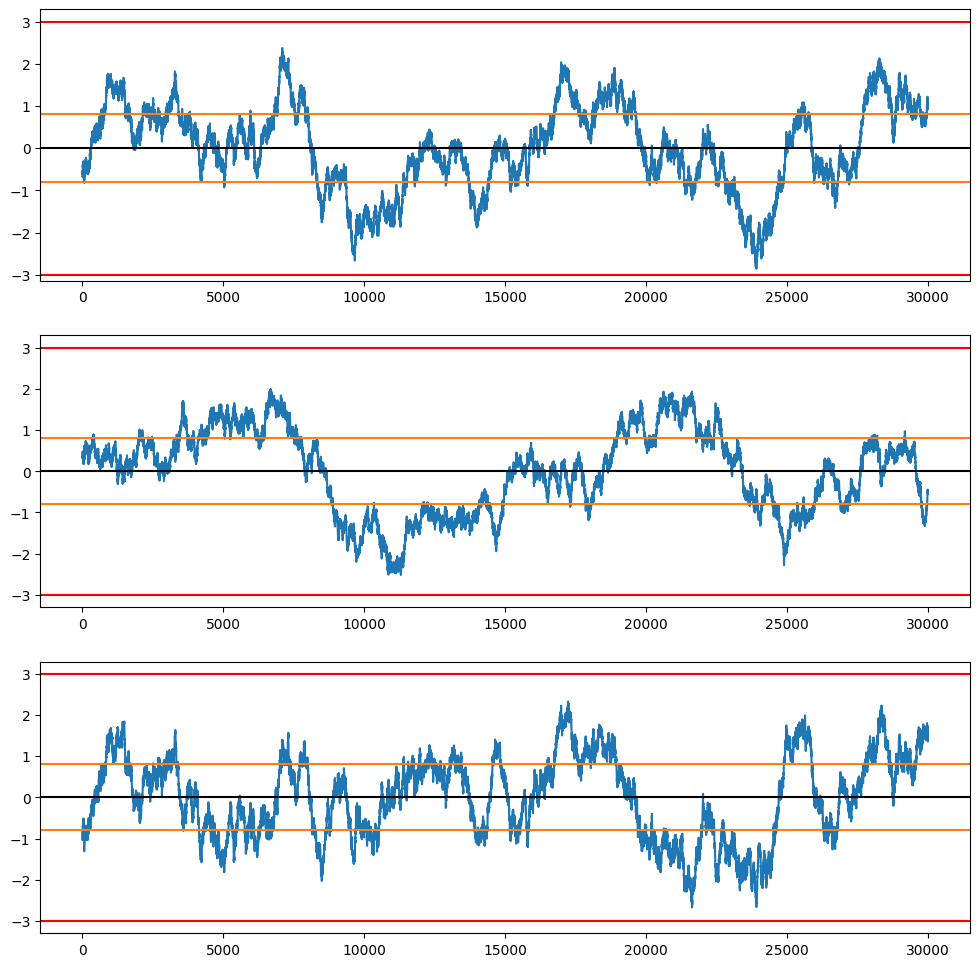

In [34]:
thr = 0.8

fig, ax = plt.subplots(3, 1, figsize=(12, 12))
for i, spr in enumerate([spr1z, spr2z, spr3z]):
    # buys = list(spr[spr < -thr].index)
    # sells = list(spr[spr > thr].index)
    # for buy in buys:
    #     ax[i].axvline(buy, c='green')
    # for sell in sells:
    #     ax[i].axvline(sell, c='red')
    ax[i].plot(spr)
    ax[i].axhline(0, c='k')
    ax[i].axhline(thr, c='tab:orange')
    ax[i].axhline(-thr, c='tab:orange')
    ax[i].axhline(3, c='r')
    ax[i].axhline(-3, c='r')
plt.show()

# Round 4

In [42]:
price_0 = pd.read_csv('../data/raw/round_2/prices_round_2_day_-1.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_2/prices_round_2_day_0.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_2/prices_round_2_day_1.csv', delimiter=';')
price_3 = pd.read_csv('../data/raw/round_3/prices_round_3_day_2.csv', delimiter=';')
price_4 = pd.read_csv('../data/raw/round_4/prices_round_4_day_3.csv', delimiter=';')

prices = pd.concat([price_0, price_1, price_2, price_3, price_4], axis=0).reset_index(drop=True)
spr1, spr2, spr3 = get_spreads(prices)
spr1z = (spr1 - spr1.mean()) / spr1.std()
spr2z = (spr2 - spr2.mean()) / spr2.std()
spr3z = (spr3 - spr3.mean()) / spr3.std()

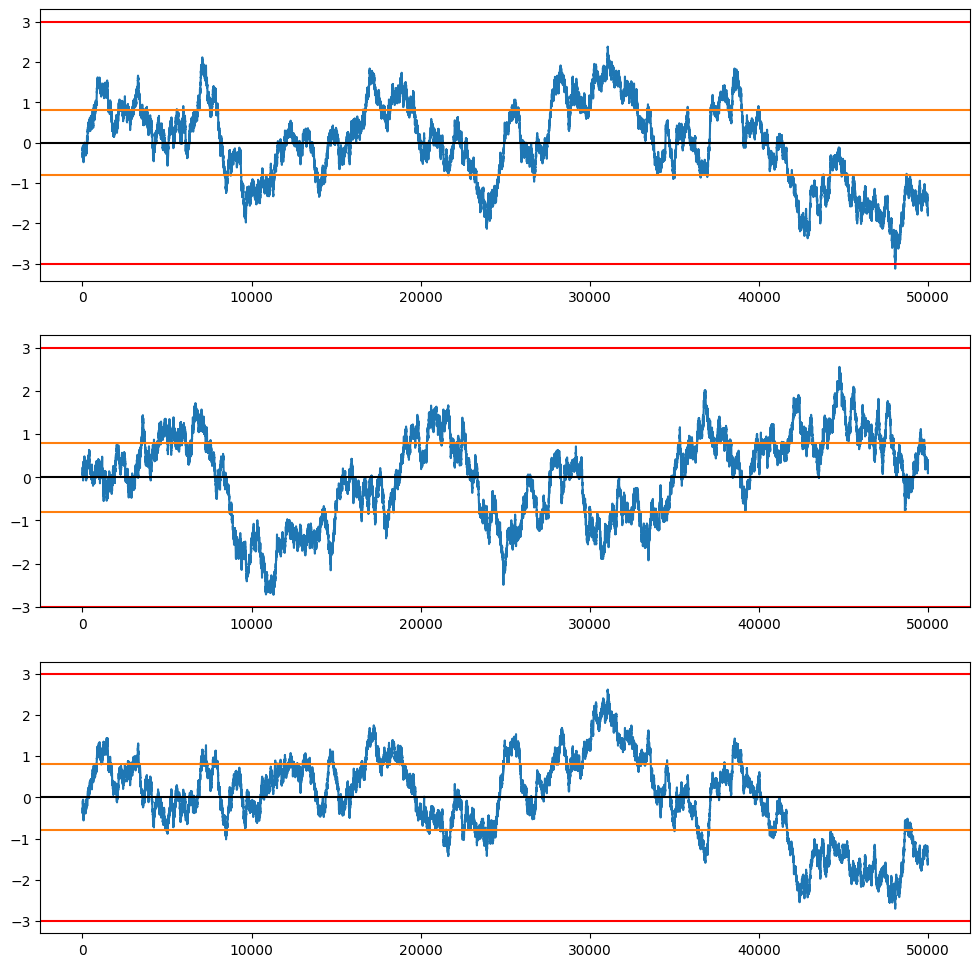

In [43]:
thr = 0.8

fig, ax = plt.subplots(3, 1, figsize=(12, 12))
for i, spr in enumerate([spr1z, spr2z, spr3z]):
    ax[i].plot(spr)
    ax[i].axhline(0, c='k')
    ax[i].axhline(thr, c='tab:orange')
    ax[i].axhline(-thr, c='tab:orange')
    ax[i].axhline(3, c='r')
    ax[i].axhline(-3, c='r')
plt.show()

In [44]:
spr3.mean(), spr3.std()

(np.float64(-15.72188), np.float64(126.36588291937393))

In [45]:
spr3.iloc[-10000:].mean(), spr3.iloc[-10000:].std()

(np.float64(-195.79715), np.float64(78.29338357912964))

# Round 5

## Fine-tuning

In [148]:
price_0 = pd.read_csv('../data/raw/round_2/prices_round_2_day_-1.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_2/prices_round_2_day_0.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_2/prices_round_2_day_1.csv', delimiter=';')
price_3 = pd.read_csv('../data/raw/round_3/prices_round_3_day_2.csv', delimiter=';')
price_4 = pd.read_csv('../data/raw/round_4/prices_round_4_day_3.csv', delimiter=';')
price_5 = pd.read_csv('../data/raw/round_5/prices_round_5_day_4.csv', delimiter=';')

_, prices_2w, _ = read_log('../data/logs/round_2/9547fd05-1a01-43b1-b6cc-b4dd5c557d2c.log')
_, prices_2f, _ = read_log('../data/logs/round_2/351a5708-c942-4a38-995c-b5e139cc1bc7_final.log')
_, prices_3w, _ = read_log('../data/logs/round_3/0f773cca-e2fa-44e9-b203-943304332c22.log')
_, prices_3f, _ = read_log('../data/logs/round_3/235590fb-d5ca-4a45-b934-cc4f5e623610_final.log')
_, prices_4w, _ = read_log('../data/logs/round_4/77fd41eb-a05e-4521-8a69-2ee522fbeaca.log')
_, prices_4f, _ = read_log('../data/logs/round_4/235590fb-d5ca-4a45-b934-cc4f5e623610_final.log')
_, prices_5w, _ = read_log('../data/logs/round_5/v0.log')

prices = pd.concat([price_0, price_1, price_2, prices_2w, prices_2f, price_3, prices_3w, prices_3f,
                    price_4, prices_4w, prices_4f, price_5, prices_5w], axis=0).reset_index(drop=True)
spr1, spr2, spr3 = get_spreads(prices)

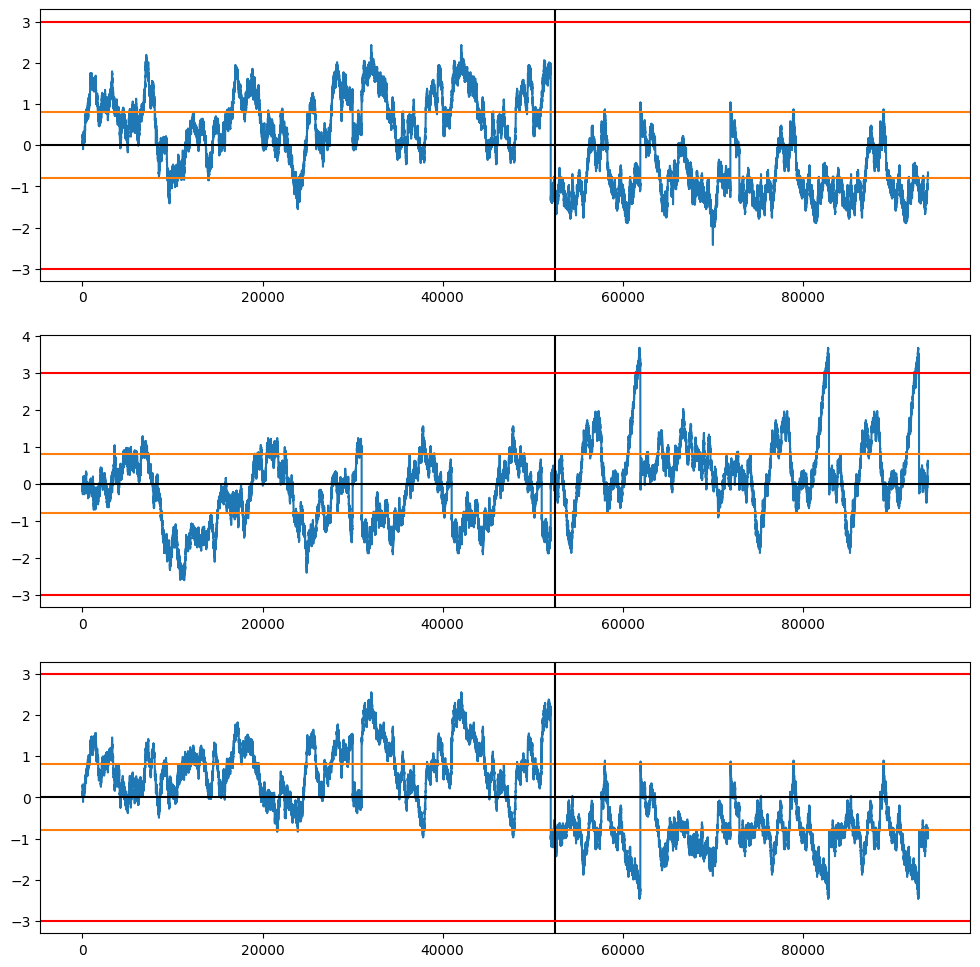

In [149]:
spr1z = (spr1 - spr1.mean()) / spr1.std()
spr2z = (spr2 - spr2.mean()) / spr2.std()
spr3z = (spr3 - spr3.mean()) / spr3.std()

thr = 0.8

fig, ax = plt.subplots(3, 1, figsize=(12, 12))
for i, spr in enumerate([spr1z, spr2z, spr3z]):
    ax[i].plot(spr)
    ax[i].axhline(0, c='k')
    ax[i].axhline(thr, c='tab:orange')
    ax[i].axhline(-thr, c='tab:orange')
    ax[i].axvline(52500, c='k')
    ax[i].axhline(3, c='r')
    ax[i].axhline(-3, c='r')
plt.show()

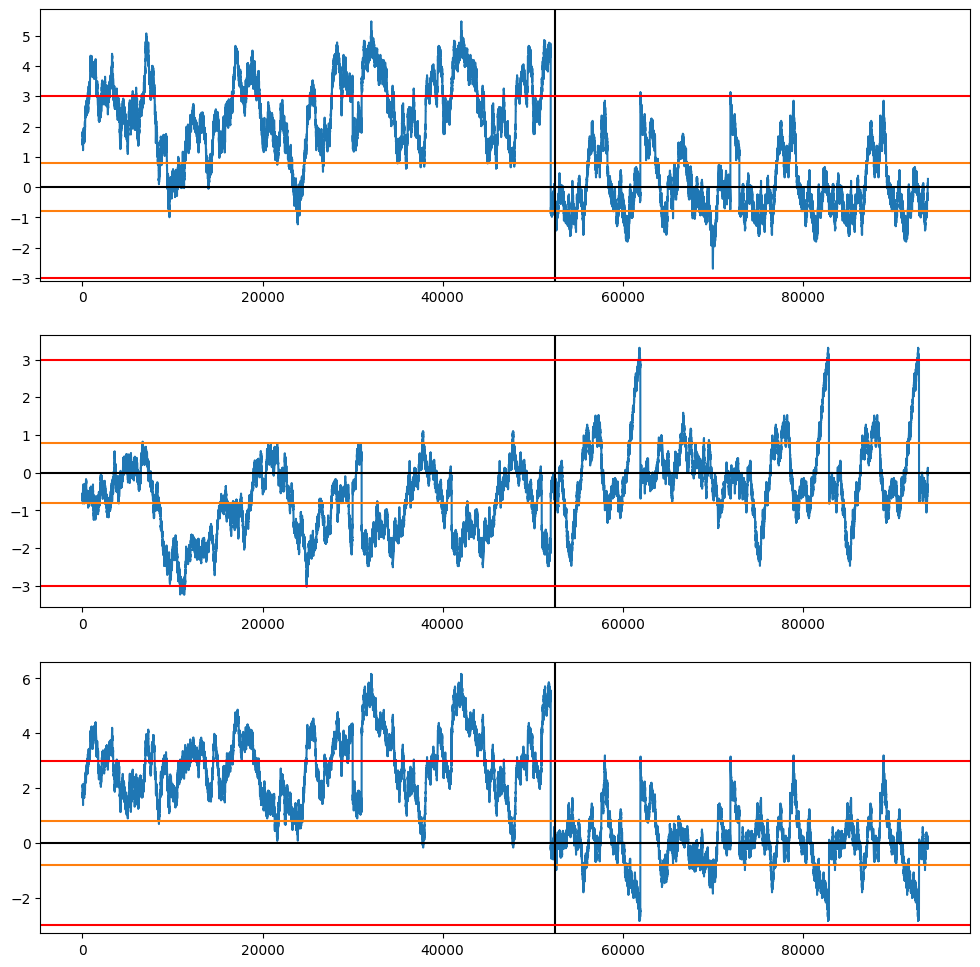

In [150]:
spr1z = (spr1 - spr1.iloc[52500:].mean()) / spr1.iloc[52500:].std()
spr2z = (spr2 - spr2.iloc[52500:].mean()) / spr2.iloc[52500:].std()
spr3z = (spr3 - spr3.iloc[52500:].mean()) / spr3.iloc[52500:].std()

thr = 0.8

fig, ax = plt.subplots(3, 1, figsize=(12, 12))
for i, spr in enumerate([spr1z, spr2z, spr3z]):
    ax[i].plot(spr)
    ax[i].axhline(0, c='k')
    ax[i].axhline(thr, c='tab:orange')
    ax[i].axhline(-thr, c='tab:orange')
    ax[i].axvline(52500, c='k')
    ax[i].axhline(3, c='r')
    ax[i].axhline(-3, c='r')
plt.show()

In [151]:
spr3.iloc[52500:].mean(), spr3.iloc[52500:].std()

(np.float64(-202.28379031283973), np.float64(83.89979702907813))

## Bot analysis

### CROISSANTS

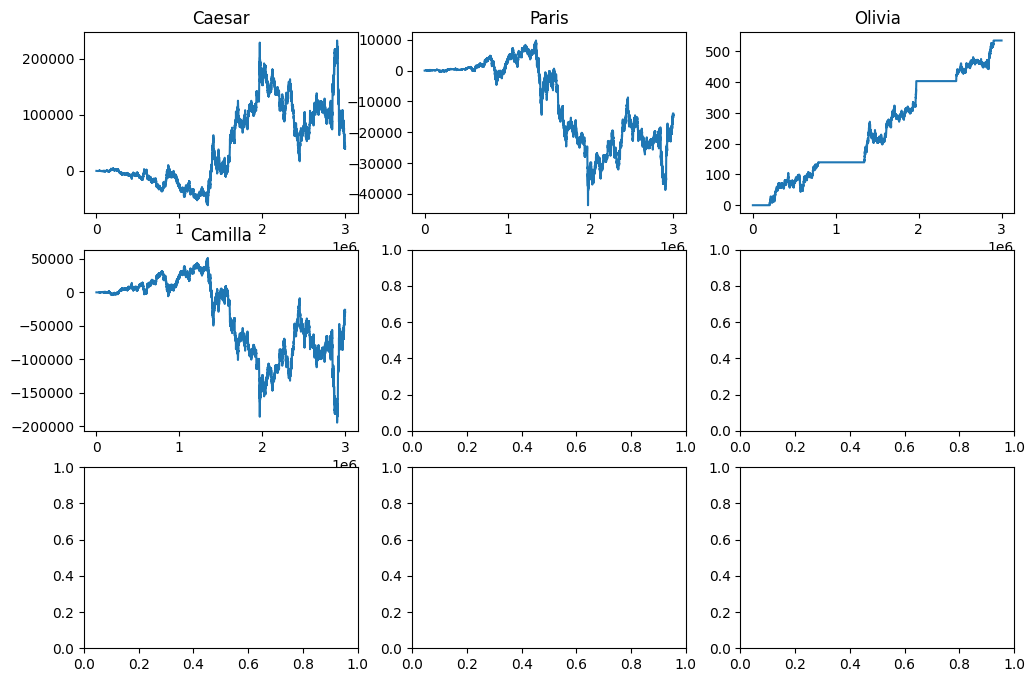

In [174]:
price_0 = pd.read_csv('../data/raw/round_5/prices_round_5_day_2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_5/prices_round_5_day_3.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_5/prices_round_5_day_4.csv', delimiter=';')

price_0 = price_0[price_0['product'] == 'CROISSANTS']
price_1 = price_1[price_1['product'] == 'CROISSANTS']
price_2 = price_2[price_2['product'] == 'CROISSANTS']

trades_0 = pd.read_csv('../data/raw/round_5/trades_round_5_day_2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_5/trades_round_5_day_3.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_5/trades_round_5_day_4.csv', delimiter=';')

trades_0 = trades_0[trades_0['symbol'] == 'CROISSANTS']
trades_1 = trades_1[trades_1['symbol'] == 'CROISSANTS']
trades_2 = trades_2[trades_2['symbol'] == 'CROISSANTS']

price_1['timestamp'] += 1_000_000
price_2['timestamp'] += 2_000_000
trades_1['timestamp'] += 1_000_000
trades_2['timestamp'] += 2_000_000

prices = pd.concat([price_0, price_1, price_2], axis=0).set_index('timestamp', drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).set_index('timestamp', drop=True)

bots = list(trades['buyer'].unique())

fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for bot, ax in zip(bots, axes.flat):
    bot_trades = trades[(trades['buyer'] == bot) | (trades['seller'] == bot)]
    position = bot_trades.apply(lambda x: x['quantity'] if x['buyer'] == bot else -x['quantity'], axis=1)
    position = position.groupby(position.index).sum().cumsum()
    position.loc[0] = 0
    prices['position'] = position
    prices['position'] = prices['position'].ffill()
    prices['pnl'] = prices['position'].shift(1) * prices['mid_price'].diff()
    prices['pnl'] = prices['pnl'].cumsum()
    
    ax.plot(prices['pnl'])
    ax.set_title(bot)
plt.show()

In [175]:
def calculate_cumulative_pnl(df, buy_times, sell_times):
    df['buy'] = 0
    df['sell'] = 0
    df.loc[buy_times, 'buy'] = 1
    df.loc[sell_times, 'sell'] = 1
    
    df["long_position"] = (df["buy"] * df["ask_volume_1"]).cumsum()

    # Average entry price for the long side (volume-weighted)
    df["long_cost"] = (df["buy"] * df["ask_volume_1"] * df["ask_price_1"]).cumsum()
    
    # Average price of long holdings (VWAP)
    df["avg_long_price"] = df["long_cost"] / df["long_position"]
    df["avg_long_price"] = df["avg_long_price"].fillna(0)
    
    # Long PnL = holding size × (current mid - avg buy price)
    df["long_pnl"] = df["long_position"] * (df["mid_price"] - df["avg_long_price"])
    
    # Same logic for short positions
    df["short_position"] = (df["sell"] * df["bid_volume_1"]).cumsum()
    df["short_cost"] = (df["sell"] * df["bid_volume_1"] * df["bid_price_1"]).cumsum()
    df["avg_short_price"] = df["short_cost"] / df["short_position"]
    df["avg_short_price"] = df["avg_short_price"].fillna(0)
    
    # Short PnL = short size × (avg sell price - current mid)
    df["short_pnl"] = df["short_position"] * (df["avg_short_price"] - df["mid_price"])
    
    # Total unrealized PnL
    df["pnl"] = df["long_pnl"] + df["short_pnl"]
    return df["pnl"]

In [176]:
results = {}
for b1 in bots:
    for b2 in bots:
        for b3 in bots:
            for b4 in bots:
                buy_idx = trades[(trades['buyer'] == b1) & (trades['seller'] == b2)].index + 100
                sell_idx = trades[(trades['buyer'] == b3) & (trades['seller'] == b4)].index + 100
                pnl = calculate_cumulative_pnl(prices, buy_idx, sell_idx)
                results[(b1, b2, b3, b4)] = pnl.iloc[-1] / pnl.diff().std() if pnl.diff().std() > 0 else 0

In [177]:
max(results.values())

np.float64(571.545448836763)

In [178]:
[k for k, v in results.items() if v == max(results.values())][0]

('Olivia', 'Caesar', 'Caesar', 'Olivia')

In [179]:
b1, b2, b3, b4 = [k for k, v in results.items() if v == max(results.values())][0]

buy_idx = trades[(trades['buyer'] == b1) & (trades['seller'] == b2)].index + 100
sell_idx = trades[(trades['buyer'] == b3) & (trades['seller'] == b4)].index + 100
pnl = calculate_cumulative_pnl(prices, buy_idx, sell_idx)

<Axes: xlabel='timestamp'>

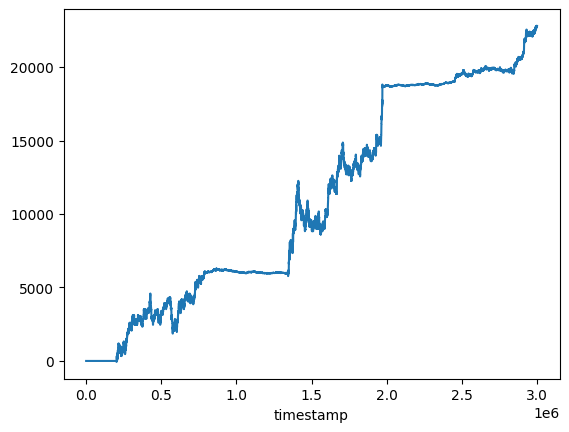

In [180]:
pnl.plot()

### JAMS

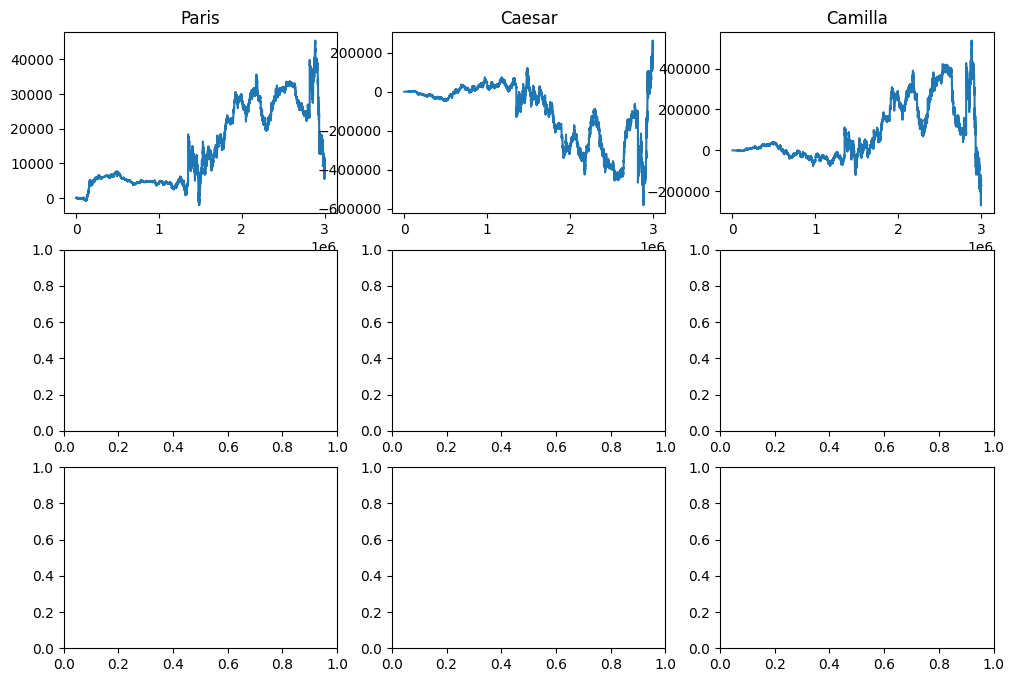

In [181]:
price_0 = pd.read_csv('../data/raw/round_5/prices_round_5_day_2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_5/prices_round_5_day_3.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_5/prices_round_5_day_4.csv', delimiter=';')

price_0 = price_0[price_0['product'] == 'JAMS']
price_1 = price_1[price_1['product'] == 'JAMS']
price_2 = price_2[price_2['product'] == 'JAMS']

trades_0 = pd.read_csv('../data/raw/round_5/trades_round_5_day_2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_5/trades_round_5_day_3.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_5/trades_round_5_day_4.csv', delimiter=';')

trades_0 = trades_0[trades_0['symbol'] == 'JAMS']
trades_1 = trades_1[trades_1['symbol'] == 'JAMS']
trades_2 = trades_2[trades_2['symbol'] == 'JAMS']

price_1['timestamp'] += 1_000_000
price_2['timestamp'] += 2_000_000
trades_1['timestamp'] += 1_000_000
trades_2['timestamp'] += 2_000_000

prices = pd.concat([price_0, price_1, price_2], axis=0).set_index('timestamp', drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).set_index('timestamp', drop=True)

bots = list(trades['buyer'].unique())

fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for bot, ax in zip(bots, axes.flat):
    bot_trades = trades[(trades['buyer'] == bot) | (trades['seller'] == bot)]
    position = bot_trades.apply(lambda x: x['quantity'] if x['buyer'] == bot else -x['quantity'], axis=1)
    position = position.groupby(position.index).sum().cumsum()
    position.loc[0] = 0
    prices['position'] = position
    prices['position'] = prices['position'].ffill()
    prices['pnl'] = prices['position'].shift(1) * prices['mid_price'].diff()
    prices['pnl'] = prices['pnl'].cumsum()
    
    ax.plot(prices['pnl'])
    ax.set_title(bot)
plt.show()

In [182]:
results = {}
for b1 in bots:
    for b2 in bots:
        for b3 in bots:
            for b4 in bots:
                buy_idx = trades[(trades['buyer'] == b1) & (trades['seller'] == b2)].index + 100
                sell_idx = trades[(trades['buyer'] == b3) & (trades['seller'] == b4)].index + 100
                pnl = calculate_cumulative_pnl(prices, buy_idx, sell_idx)
                results[(b1, b2, b3, b4)] = pnl.iloc[-1] / pnl.diff().std() if pnl.diff().std() > 0 else 0

In [183]:
max(results.values())

np.float64(59.21860450691928)

In [184]:
[k for k, v in results.items() if v == max(results.values())][0]

('Camilla', 'Paris', 'Paris', 'Paris')

<Axes: xlabel='timestamp'>

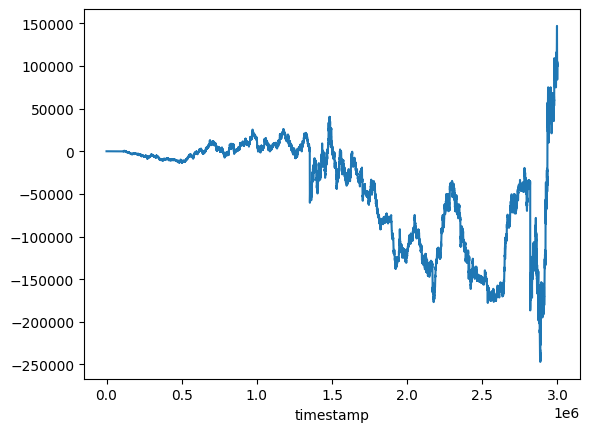

In [185]:
b1, b2, b3, b4 = [k for k, v in results.items() if v == max(results.values())][0]

buy_idx = trades[(trades['buyer'] == b1) & (trades['seller'] == b2)].index + 100
sell_idx = trades[(trades['buyer'] == b3) & (trades['seller'] == b4)].index + 100
pnl = calculate_cumulative_pnl(prices, buy_idx, sell_idx)

pnl.plot()

### DJEMBES

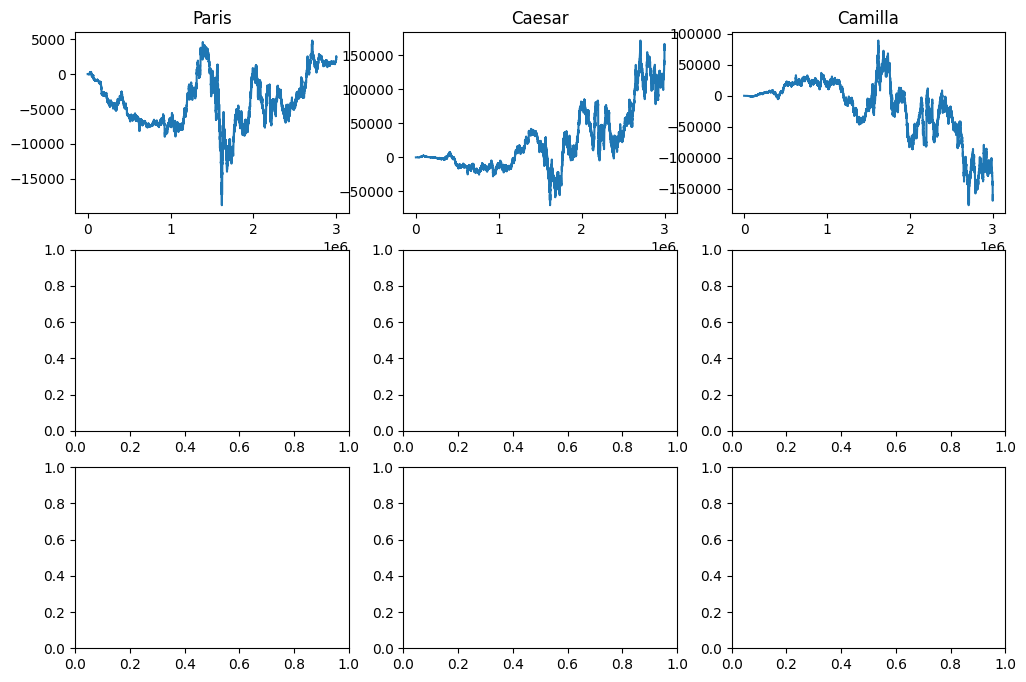

In [186]:
price_0 = pd.read_csv('../data/raw/round_5/prices_round_5_day_2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_5/prices_round_5_day_3.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_5/prices_round_5_day_4.csv', delimiter=';')

price_0 = price_0[price_0['product'] == 'DJEMBES']
price_1 = price_1[price_1['product'] == 'DJEMBES']
price_2 = price_2[price_2['product'] == 'DJEMBES']

trades_0 = pd.read_csv('../data/raw/round_5/trades_round_5_day_2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_5/trades_round_5_day_3.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_5/trades_round_5_day_4.csv', delimiter=';')

trades_0 = trades_0[trades_0['symbol'] == 'DJEMBES']
trades_1 = trades_1[trades_1['symbol'] == 'DJEMBES']
trades_2 = trades_2[trades_2['symbol'] == 'DJEMBES']

price_1['timestamp'] += 1_000_000
price_2['timestamp'] += 2_000_000
trades_1['timestamp'] += 1_000_000
trades_2['timestamp'] += 2_000_000

prices = pd.concat([price_0, price_1, price_2], axis=0).set_index('timestamp', drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).set_index('timestamp', drop=True)

bots = list(trades['buyer'].unique())

fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for bot, ax in zip(bots, axes.flat):
    bot_trades = trades[(trades['buyer'] == bot) | (trades['seller'] == bot)]
    position = bot_trades.apply(lambda x: x['quantity'] if x['buyer'] == bot else -x['quantity'], axis=1)
    position = position.groupby(position.index).sum().cumsum()
    position.loc[0] = 0
    prices['position'] = position
    prices['position'] = prices['position'].ffill()
    prices['pnl'] = prices['position'].shift(1) * prices['mid_price'].diff()
    prices['pnl'] = prices['pnl'].cumsum()
    
    ax.plot(prices['pnl'])
    ax.set_title(bot)
plt.show()

In [187]:
results = {}
for b1 in bots:
    for b2 in bots:
        for b3 in bots:
            for b4 in bots:
                buy_idx = trades[(trades['buyer'] == b1) & (trades['seller'] == b2)].index + 100
                sell_idx = trades[(trades['buyer'] == b3) & (trades['seller'] == b4)].index + 100
                pnl = calculate_cumulative_pnl(prices, buy_idx, sell_idx)
                results[(b1, b2, b3, b4)] = pnl.iloc[-1] / pnl.diff().std() if pnl.diff().std() > 0 else 0

In [188]:
max(results.values())

np.float64(154.26962411196052)

In [189]:
[k for k, v in results.items() if v == max(results.values())][0]

('Caesar', 'Camilla', 'Paris', 'Camilla')

<Axes: xlabel='timestamp'>

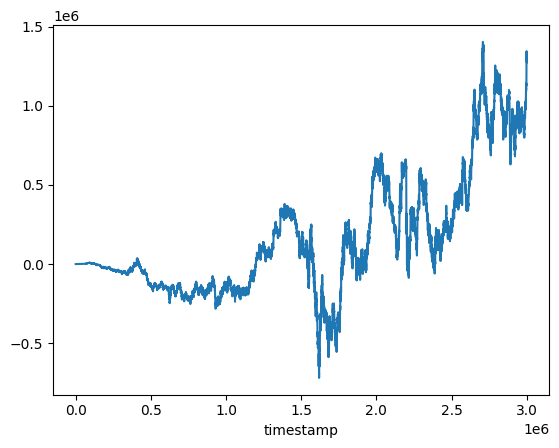

In [190]:
b1, b2, b3, b4 = [k for k, v in results.items() if v == max(results.values())][0]

buy_idx = trades[(trades['buyer'] == b1) & (trades['seller'] == b2)].index + 100
sell_idx = trades[(trades['buyer'] == b3) & (trades['seller'] == b4)].index + 100
pnl = calculate_cumulative_pnl(prices, buy_idx, sell_idx)

pnl.plot()

### PICNIC_BASKET1

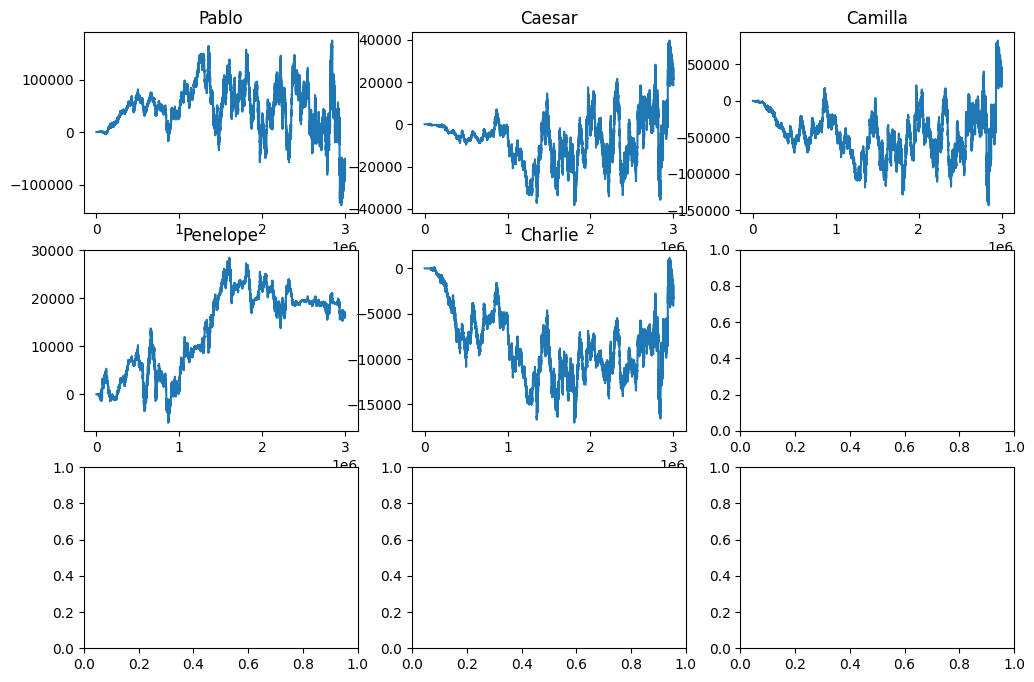

In [191]:
price_0 = pd.read_csv('../data/raw/round_5/prices_round_5_day_2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_5/prices_round_5_day_3.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_5/prices_round_5_day_4.csv', delimiter=';')

price_0 = price_0[price_0['product'] == 'PICNIC_BASKET1']
price_1 = price_1[price_1['product'] == 'PICNIC_BASKET1']
price_2 = price_2[price_2['product'] == 'PICNIC_BASKET1']

trades_0 = pd.read_csv('../data/raw/round_5/trades_round_5_day_2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_5/trades_round_5_day_3.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_5/trades_round_5_day_4.csv', delimiter=';')

trades_0 = trades_0[trades_0['symbol'] == 'PICNIC_BASKET1']
trades_1 = trades_1[trades_1['symbol'] == 'PICNIC_BASKET1']
trades_2 = trades_2[trades_2['symbol'] == 'PICNIC_BASKET1']

price_1['timestamp'] += 1_000_000
price_2['timestamp'] += 2_000_000
trades_1['timestamp'] += 1_000_000
trades_2['timestamp'] += 2_000_000

prices = pd.concat([price_0, price_1, price_2], axis=0).set_index('timestamp', drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).set_index('timestamp', drop=True)

bots = list(trades['buyer'].unique())

fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for bot, ax in zip(bots, axes.flat):
    bot_trades = trades[(trades['buyer'] == bot) | (trades['seller'] == bot)]
    position = bot_trades.apply(lambda x: x['quantity'] if x['buyer'] == bot else -x['quantity'], axis=1)
    position = position.groupby(position.index).sum().cumsum()
    position.loc[0] = 0
    prices['position'] = position
    prices['position'] = prices['position'].ffill()
    prices['pnl'] = prices['position'].shift(1) * prices['mid_price'].diff()
    prices['pnl'] = prices['pnl'].cumsum()
    
    ax.plot(prices['pnl'])
    ax.set_title(bot)
plt.show()

In [192]:
results = {}
for b1 in bots:
    for b2 in bots:
        for b3 in bots:
            for b4 in bots:
                buy_idx = trades[(trades['buyer'] == b1) & (trades['seller'] == b2)].index + 100
                sell_idx = trades[(trades['buyer'] == b3) & (trades['seller'] == b4)].index + 100
                pnl = calculate_cumulative_pnl(prices, buy_idx, sell_idx)
                results[(b1, b2, b3, b4)] = pnl.iloc[-1] / pnl.diff().std() if pnl.diff().std() > 0 else 0

In [193]:
max(results.values())

np.float64(74.1909370271624)

In [194]:
[k for k, v in results.items() if v == max(results.values())][0]

('Camilla', 'Caesar', 'Penelope', 'Charlie')

<Axes: xlabel='timestamp'>

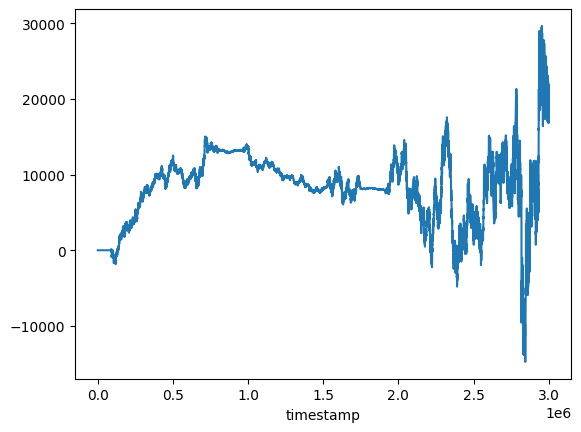

In [195]:
b1, b2, b3, b4 = [k for k, v in results.items() if v == max(results.values())][0]

buy_idx = trades[(trades['buyer'] == b1) & (trades['seller'] == b2)].index + 100
sell_idx = trades[(trades['buyer'] == b3) & (trades['seller'] == b4)].index + 100
pnl = calculate_cumulative_pnl(prices, buy_idx, sell_idx)

pnl.plot()

### PICNIC_BASKET2

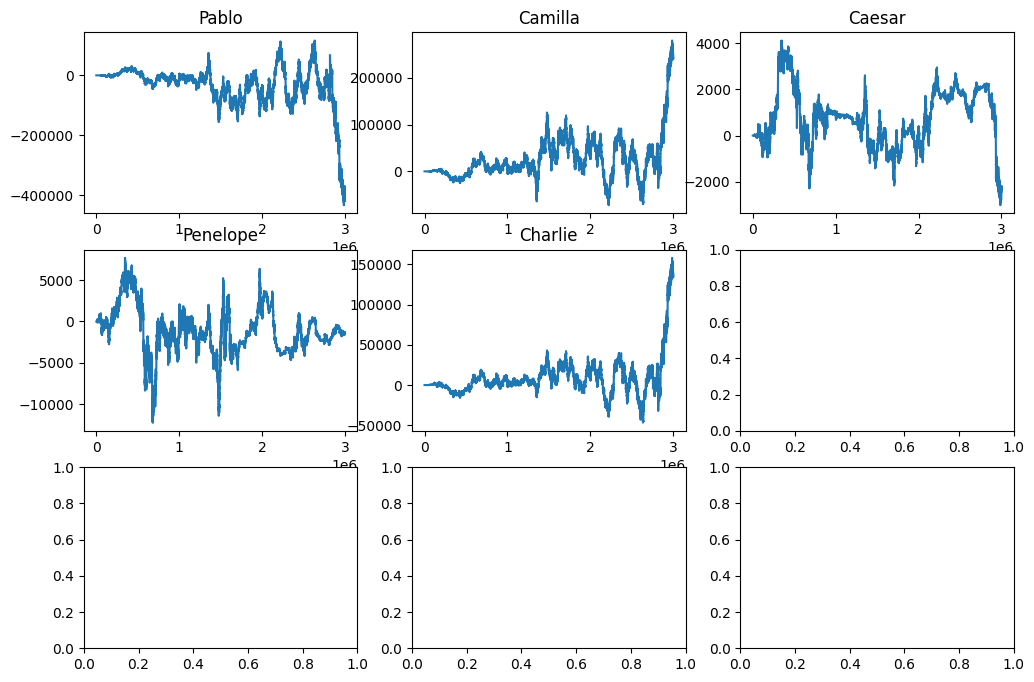

In [196]:
price_0 = pd.read_csv('../data/raw/round_5/prices_round_5_day_2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_5/prices_round_5_day_3.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_5/prices_round_5_day_4.csv', delimiter=';')

price_0 = price_0[price_0['product'] == 'PICNIC_BASKET2']
price_1 = price_1[price_1['product'] == 'PICNIC_BASKET2']
price_2 = price_2[price_2['product'] == 'PICNIC_BASKET2']

trades_0 = pd.read_csv('../data/raw/round_5/trades_round_5_day_2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_5/trades_round_5_day_3.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_5/trades_round_5_day_4.csv', delimiter=';')

trades_0 = trades_0[trades_0['symbol'] == 'PICNIC_BASKET2']
trades_1 = trades_1[trades_1['symbol'] == 'PICNIC_BASKET2']
trades_2 = trades_2[trades_2['symbol'] == 'PICNIC_BASKET2']

price_1['timestamp'] += 1_000_000
price_2['timestamp'] += 2_000_000
trades_1['timestamp'] += 1_000_000
trades_2['timestamp'] += 2_000_000

prices = pd.concat([price_0, price_1, price_2], axis=0).set_index('timestamp', drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).set_index('timestamp', drop=True)

bots = list(trades['buyer'].unique())

fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for bot, ax in zip(bots, axes.flat):
    bot_trades = trades[(trades['buyer'] == bot) | (trades['seller'] == bot)]
    position = bot_trades.apply(lambda x: x['quantity'] if x['buyer'] == bot else -x['quantity'], axis=1)
    position = position.groupby(position.index).sum().cumsum()
    position.loc[0] = 0
    prices['position'] = position
    prices['position'] = prices['position'].ffill()
    prices['pnl'] = prices['position'].shift(1) * prices['mid_price'].diff()
    prices['pnl'] = prices['pnl'].cumsum()
    
    ax.plot(prices['pnl'])
    ax.set_title(bot)
plt.show()

In [197]:
results = {}
for b1 in bots:
    for b2 in bots:
        for b3 in bots:
            for b4 in bots:
                buy_idx = trades[(trades['buyer'] == b1) & (trades['seller'] == b2)].index + 100
                sell_idx = trades[(trades['buyer'] == b3) & (trades['seller'] == b4)].index + 100
                pnl = calculate_cumulative_pnl(prices, buy_idx, sell_idx)
                results[(b1, b2, b3, b4)] = pnl.iloc[-1] / pnl.diff().std() if pnl.diff().std() > 0 else 0

In [198]:
max(results.values())

np.float64(246.74000968950435)

In [199]:
[k for k, v in results.items() if v == max(results.values())][0]

('Charlie', 'Pablo', 'Caesar', 'Penelope')

<Axes: xlabel='timestamp'>

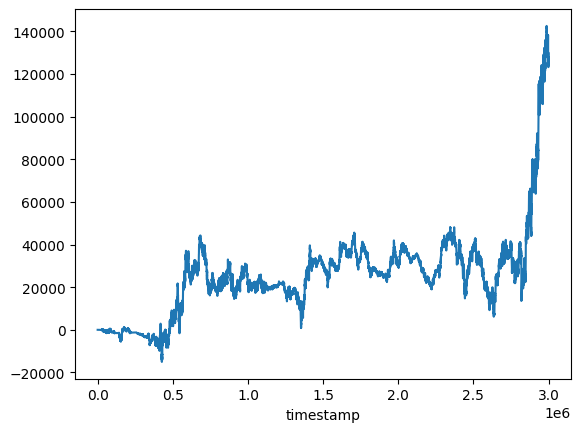

In [201]:
b1, b2, b3, b4 = [k for k, v in results.items() if v == max(results.values())][0]

buy_idx = trades[(trades['buyer'] == b1) & (trades['seller'] == b2)].index + 100
sell_idx = trades[(trades['buyer'] == b3) & (trades['seller'] == b4)].index + 100
pnl = calculate_cumulative_pnl(prices, buy_idx, sell_idx)

pnl.plot()